In [2]:
#se importan las librerias
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline   
#%matplotlib qt  
nm=1e-9
um=1e-6
mm=1e-3
cm=1e-2

In [3]:
#Función DFT En 2 dimensiones

def DFF_2D(entrada):
    M, N = np.shape(entrada)
    #Malla de la matriz
    dft2d = np.zeros((M,N),dtype="complex")
    
    #Fourier transform
    for i in range(0,N):
        for j in range(0,M):
         for m in range(0,N):
            for n in range(0,M):
                dft2d[i,j] +=entrada[m,n]*np.exp((-1j*2*np.pi)*((i*m/N) + (j*n/M)))

    return dft2d

In [1]:
#Función IDFT En 2 dimensiones

def IDFF_2D(entrada):
    M, N = np.shape(entrada)
    #Malla de la matriz
    dft2d = np.zeros((M,N),dtype="complex")
    
    #Fourier transform
    for i in range(0,N):
        for j in range(0,M):
         for m in range(0,N):
            for n in range(0,M):
                dft2d[i,j] +=entrada[m,n]*np.exp((1j*2*np.pi)*((i*m/N) + (j*n/M)))

    return dft2d

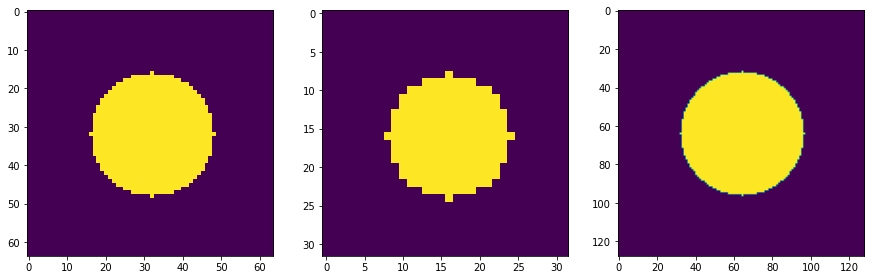

In [12]:
#Apertura circular
mask=np.zeros((64,64),dtype="uint8")
cv2.circle(mask,(32,32),16,1,-1)

mask1=np.zeros((32,32),dtype="uint8")
cv2.circle(mask1,(16,16),8,1,-1)

mask2=np.zeros((128,128),dtype="uint8")
cv2.circle(mask2,(64,64),32,1,-1)

fig, ax = plt.subplots(1,3,figsize=(15, 15))

plt.imshow(mask2)
ax[0].imshow(mask)
ax[1].imshow(mask1)
ax[2].imshow(mask2)
plt.show()


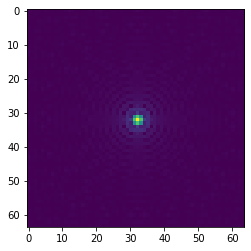

In [14]:
#Transformada de Fresnel FFT
def TrFr(entrada,z,dx,dy,W_l):
    #Contenido frecuencial de la imagen (transformada de fourier)
    k= 2*np.pi/W_l
    N,M= np.shape(entrada)
    x=np.arange(-int(N/2),int(N/2),1)
    y=np.arange(-int(M/2),int(M/2),1)
    X, Y=np.meshgrid(x,y)
    X0, Y0=np.meshgrid(x,y)

    #concidion de buen muestreo
    dx_0=(W_l*z)/(M*dx)
    dy_0=(W_l*z)/(N*dy)

    fx=X0*(1/(N*dx_0))
    fy=Y0*(1/(M*dy_0))
    
    #Constante de U_0
    C1= (1j*(k/(2*z)))
    U_1 = entrada*np.exp(C1*(((X*dx)**2) + ((Y*dy)**2)))
    U_2 = np.fft.fft2(U_1)

    #Constantes de U_2
    C2= ((np.exp(1j*k*z))/(1j*W_l*z))
    C3= 1j*(k/(2*z))

    U_3= U_2*C2*np.exp(C3*(((fx)**2) + ((fy)**2)))
    
    return U_3

plt.imshow(np.abs(np.fft.fftshift((TrFr(mask,0.1,1*um,1*um,632.8*nm)))))
plt.show()
    

In [ ]:
#Transformada de Fresnel DFT
def TrFrD(entrada,z,dx,dy,W_l):
    #Contenido frecuencial de la imagen (transformada de fourier)
    k= 2*np.pi/W_l
    N,M= np.shape(entrada)
    x=np.arange(-int(N/2),int(N/2),1)
    y=np.arange(-int(M/2),int(M/2),1)
    X, Y=np.meshgrid(x,y)
    X_0, Y_0 =np.meshgrid(x,y)

    #concidion de buen muestreo
    dx_0=(W_l*z)/(M*dx)
    dy_0=(W_l*z)/(N*dy)

    #Constante de U_0
    C1= ((1j*k)/(2*z))

    U_1 = entrada*np.exp(C1*(((X_0*dx_0)**2) + ((Y_0*dy_0)**2)))

    U_2 = DFF_2D(U_1)

    #Constantes de U_2
    C2= np.exp(1j*k*z)/(1j*W_l*z)
    C3= ((1j*k)/(2*z))

    U_3= U_2*C2*np.exp(C3*(((X*dx)**2) + ((Y*dy)**2)))
    
    return U_3

plt.imshow(np.abs(np.fft.fftshift((TrFrD(mask,0.13,1,1,650)))))
plt.show()

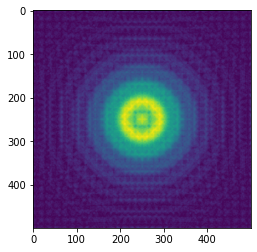

In [5]:
# ESPECTRO ANGULAR POR FFT
def AngFT(entrada,z,dx,dy,wavelength):
    k=2*np.pi/wavelength
    U_0=entrada
    A_0=np.fft.fftshift(np.fft.fft2(U_0))
    N,M= np.shape(U_0)
    x=np.arange(-int(N/2),int(N/2),1)
    y=np.arange(-int(M/2),int(M/2),1)
    X, Y=np.meshgrid(x,y)

    #dimensiones de mundo en frecuencias
    fx=X*(1/(N*dx))
    fy=Y*(1/(M*dy))

    #transferencia
    H=np.exp(1j*k*z* np.emath.sqrt( 1 - (wavelength**2)*(fx**2+fy**2)  ))
    A_z=A_0*H
    U_z=np.fft.ifft2(A_z)
        
    return U_z

plt.imshow(np.abs(AngFT(mask2,1*cm,1*um,1*um,650*nm)))
plt.show()


In [ ]:
# ESPECTRO ANGULAR POR DFT
def AngFT(entrada,z,dx,dy,wavelength):
     
    U_0= entrada
    N_y,N_x=np.shape(U_0)

    k = 2 * np.pi / wavelength

    delta_fx=1/dx
    delta_fy=1/dy

    fx = np.fft.fftfreq(N_x, 1/(delta_fx*N_x))
    fy = np.fft.fftfreq(N_y, 1/(delta_fy*N_y))

    Fx, Fy = np.meshgrid(fx, fy)

    #calculo el espectro inicial
    A_0=DFF_2D(U_0)

    #transferencia
    A_z = np.zeros((len(Fx), len(Fy)), dtype = np.complex_)
    a=k**2 - 2*np.pi*(Fx**2+Fy**2)
    b=a<0
    H = np.exp(1j*z*np.emath.sqrt(a))
    A_z=A_0*H

    #inverse fourier
    U_z = IDFF_2D(A_z)
    
    return U_z

plt.imshow(np.abs(((AngFT(mask2,10*mm,1*mm,1*mm,650*nm)))))
plt.show()
